In [1]:
## Task discription: Get elevation of air quality stations of London from ASTGDEMv2 data.

# Note: 
#     1. Remove overlapped elements of source ASTGDEMv2 data in WGS-84 GCS.
#     2. Merge reformed ASTGDEMv2 data in WGS-84 GCS.
#     3. Transform ASTGDEMv2 data from WGS-84 [EPSG-4326 GCS] to OSGB-36 [EPSG-4277 GCS].
#     4. Project ASTGDEMv2 data x2.
#     5. Display ASTGDEMv2 data x2.
#     6. Get elevation of air quality stations x2.
# Note:
#     EPSG    -  European Petroleum Survey Group
#     GCS     -  Geographic Coordinate System
#     PCS     -  Projected Coordinate System
#     WGS-84  -  World Geodetic System 1984 [GCS]
#     Web...  -  Web Mercator or Pseudo Mercator [PCS of WGS-84]
#     OSGB-36 -  Ordnance Survey Great Britain 1936 [GCS]
#     BNG     -  British National Grid [PCS of OSGB-36]


In [2]:
import os, sys
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import re
from pandas import read_csv
import math


In [3]:
def get_FileName(file_path, file_type):
    files = [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]
    
    file_names = []
    for i in files:
        if file_type in i:
            file_names.append(i)
    
    return file_names


def get_TifInfo(dem_data, tag_print):
    dem_row = dem_data.RasterYSize  # Height.
    dem_col = dem_data.RasterXSize  # Width.
    dem_band = dem_data.RasterCount
    dem_geotran = dem_data.GetGeoTransform()
    dem_proj = dem_data.GetProjection()
    
    if tag_print == 1:
        print('===> The number of rows of DEM array is: %d (height).' % dem_row)
        print('===> The number of cols of DEM array is: %d (width).' % dem_col)
        print('===> The number of bands of DEM array is: %d.' % dem_band)
        print('===> The 6 GeoTransform parameters of DEM data is:')
        print(dem_geotran)
        print('===> The projection information of DEM data is:')
        print(dem_proj)
    
    return dem_row, dem_col, dem_band, dem_geotran, dem_proj


def write_TIF(dem_array, dem_row, dem_col, dem_band, dem_geotran, dem_proj, path):
    data_type = gdal.GDT_UInt16
    
    if len(dem_array.shape) == 3:
        dem_bands, dem_row, dem_col = dem_array.shape
    elif len(dem_array.shape) == 2:
        dem_array = np.array([dem_array])
    else:
        dem_bands, (dem_row, dem_col) = 1, dem_array.shape  # Important.
    
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, dem_col, dem_row, dem_band, data_type)  # Order.
    if(dataset!= None):
        dataset.SetGeoTransform(dem_geotran)
        dataset.SetProjection(dem_proj)
    for i in range(dem_band):
        dataset.GetRasterBand(i+1).WriteArray(dem_array[i])
    del dataset
    
    return 0


def show_ProjDEM(file_path, file_name, img_path, img_name):
    gdal_data = gdal.Open(file_path + file_name)

    gdal_array = gdal_data.ReadAsArray().astype(np.float)
    gdal_band = gdal_data.GetRasterBand(1)
    nodataval = gdal_band.GetNoDataValue()
    if np.any(gdal_array == nodataval):
        gdal_array[gdal_array == nodataval] = np.nan
    print('*==> The shape of the DEM array is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))
    
    print('>>>> Plot DEM image.')
    fig = plt.figure(figsize=(5, 10))
    plt.title('2D Image of ' + img_name)
    plt.imshow(gdal_array)
    plt.show()
    
    save_path = img_path
    if os.path.exists(save_path) == False:
            os.mkdir(save_path)
    fig.savefig(save_path + img_name + '.png')
    
    return 0


def get_Elevation(gcs_data, site_latlog):
    gt = gcs_data.GetGeoTransform()
    print(gt)
    print('\n')
    
    gcs_array = gcs_data.ReadAsArray().astype(np.float)
    gcs_band = gcs_data.GetRasterBand(1)
    nodataval = gcs_band.GetNoDataValue()
    if np.any(gcs_array == nodataval):
        gcs_array[gcs_array == nodataval] = np.nan
    
    M = site_latlog.shape[0]
    Xgeo = site_latlog[:, 1]  # longitude.
    Ygeo = site_latlog[:, 0]  # latitude.
    
    ele = np.zeros((M, 6))  # The elevation of M locations.
    for i in range(M):
        # Note:
        # Xgeo = GT[0] + Xpixel*GT[1] + Yline*GT[2]
        # Ygeo = GT[3] + Xpixel*GT[4] + Yline*GT[5]
        #
        # Xpixel = Pixel/column of DEM image
        # Yline  = Line/row of DEM image
        #
        # Xgeo = Longitude
        # Ygeo = Latitude
        #
        # [0] = Longitude of left-top piexl
        # [3] = Latitude of left-top pixel
        #
        # [1] = + Pixel width
        # [5] = - Pixel height
        #
        # [2] = 0 for north up image
        # [4] = 0 for north up image
        
        Xpixel = int(round((Xgeo[i] - gt[0])/gt[1]))
        Yline  = int(round((Ygeo[i] - gt[3])/gt[5]))
        
        ele[i, 0] = int(i)
        ele[i, 1] = Ygeo[i]
        ele[i, 2] = Xgeo[i]
        ele[i, 3] = Yline
        ele[i, 4] = Xpixel
        ele[i, 5] = gcs_array[Yline, Xpixel]  # The elevation of i-th location.
    
    return ele



In [4]:
path_source = "DATA_ASTGDEMv2/EPSG4326/"
path = "DATA_ASTGDEMv2/EPSG4326_rm/"
file_type = ".tif"


In [5]:
### Remove overlapped elements of ASTGDEMv2 data (WGS-84 GCS).

file_names = get_FileName(path_source, file_type)
file_names.sort(reverse=True)  # W -> E.
for i, name in enumerate(file_names):
    print('\n>>> Process the %d-th DEM file: %s.' % (i+1, name))
    
    gdal_data = gdal.Open(path_source + name)
    tag = 0  # Not print info.
    row, col, band, geotran, proj = get_TifInfo(gdal_data, tag)
    gdal_array = gdal_data.ReadAsArray().astype(np.float)
    print('*==> The shape of DEM array is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))
    
    gdal_band = gdal_data.GetRasterBand(1)
    nodataval = gdal_band.GetNoDataValue()
    if np.any(gdal_array == nodataval):
        gdal_array[gdal_array == nodataval] = np.nan
    
    gdal_array = np.delete(gdal_array, -1, axis=0)  # Delete Last/Bottom Row.
    gdal_array = np.delete(gdal_array, -1, axis=1)  # Delete Last/Right Col.
    print('*==> The shape of reformed DEM array is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))
    
    if os.path.exists(path) == False:
        os.mkdir(path)
    tmp_path = path + name
    print('\n>>> Write reformed DEM data to TIF file.')
    write_TIF(gdal_array, gdal_array.shape[0], gdal_array.shape[1], band, geotran, proj, tmp_path)

print('\n>>> Complete!\n')



>>> Process the 1-th DEM file: ASTGTM2_N51W001_dem.tif.
*==> The shape of DEM array is: [3601, 3601].
*==> The shape of reformed DEM array is: [3600, 3600].

>>> Write reformed DEM data to TIF file.

>>> Process the 2-th DEM file: ASTGTM2_N51E000_dem.tif.
*==> The shape of DEM array is: [3601, 3601].
*==> The shape of reformed DEM array is: [3600, 3600].

>>> Write reformed DEM data to TIF file.

>>> Complete!



In [6]:
### Merge reformed ASTGDEMv2 data (WGS-84 GCS).

dem_out_name = "ASTGDEMv2_merged_EPSG4326.tif"

file_names = get_FileName(path, file_type)
file_names.sort(reverse=True)  # W -> E.
dem_merged_array = []
for i, name in enumerate(file_names):
    if "ASTGTM2" in name:  # Select ASTGTM2_***.tif files.
        print('\n>>> Process the %d-th DEM file: %s.' % (i+1, name))

        gdal_data = gdal.Open(path + name)
        gdal_array = gdal_data.ReadAsArray().astype(np.float)
        print('*==> The shape of DEM array is: [%d, %d].' % (gdal_array.shape[0], gdal_array.shape[1]))

        gdal_band = gdal_data.GetRasterBand(1)
        nodataval = gdal_band.GetNoDataValue()
        if np.any(gdal_array == nodataval):
            gdal_array[gdal_array == nodataval] = np.nan

        # Merge DEM arrays.
        tmp = re.findall(r'-?\d+\.?\d*', name)
        tmp_Lat = tmp[1]
        tmp_Log = tmp[2]
        if tmp_Lat == '51':  # not perfect
            if tmp_Log == '001':
                dem_merged_array = gdal_array
            else:
                dem_merged_array = np.concatenate((dem_merged_array, gdal_array), axis=1)

print('\n*==> The shape of merged DEM array is: [%d, %d].' % (dem_merged_array.shape[0], dem_merged_array.shape[1]))

# Set the correct GeoTransform parameters (from the left-top DEM file)!!!
gdal_data = gdal.Open(path + file_names[0])  # the left-top DEM file.
tag = 0  # Not print info.
row, col, band, geotran, proj = get_TifInfo(gdal_data, tag)

if os.path.exists(path) == False:
    os.mkdir(path)
tmp_path = path + dem_out_name
print('\n>>> Write merged DEM data to ' + dem_out_name)
write_TIF(dem_merged_array, dem_merged_array.shape[0], dem_merged_array.shape[1], band, geotran, proj, tmp_path)

print('\n>>> Complete!\n')



>>> Process the 1-th DEM file: ASTGTM2_N51W001_dem.tif.
*==> The shape of DEM array is: [3600, 3600].

>>> Process the 2-th DEM file: ASTGTM2_N51E000_dem.tif.
*==> The shape of DEM array is: [3600, 3600].

*==> The shape of merged DEM array is: [3600, 7200].

>>> Write merged DEM data to ASTGDEMv2_merged_EPSG4326.tif

>>> Complete!



In [7]:
### Transform merged ASTGDEMv2 data from WGS-84 GCS to OSGB-36 GCS.

print('\n>>> Transform merged ASTGDEMv2 data from WGS-84 [EPSG-4326 GCS] to OSGB-36 [EPSG-4277 GCS].')

dem_in  = path + "ASTGDEMv2_merged_EPSG4326.tif"
dem_out = path + "ASTGDEMv2_merged_EPSG4277.tif"

if os.path.isfile(dem_out) == True:
    os.remove(dem_out)

command = "gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4277" + " " + dem_in + " " + dem_out  # Change EPSG Code!!!

subprocess.call(command, shell=True)

print('\n>>> Complete!\n')



>>> Transform merged ASTGDEMv2 data from WGS-84 [EPSG-4326 GCS] to OSGB-36 [EPSG-4277 GCS].

>>> Complete!



In [8]:
### Project merged ASTGDEMv2 data from WGS-84 GCS to Web Mercator PCS.

print('\n>>> Project merged ASTGDEMv2 data from WGS-84 [EPSG-4326 GCS] to Web Mercator [EPSG-3857 PCS].')

dem_in  = path + "ASTGDEMv2_merged_EPSG4326.tif"
dem_out = path + "ASTGDEMv2_merged_EPSG3857.tif"

if os.path.isfile(dem_out) == True:
    os.remove(dem_out)

command = "gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857" + " " + dem_in + " " + dem_out  # Change EPSG Code!!!

subprocess.call(command, shell=True)

print('\n>>> Complete!\n')



>>> Project merged ASTGDEMv2 data from WGS-84 [EPSG-4326 GCS] to Web Mercator [EPSG-3857 PCS].

>>> Complete!



In [9]:
### Project merged ASTGDEMv2 data from OSGB-36 GCS to BNG PCS.

print('\n>>> Project merged ASTGDEMv2 data from OSGB-36 [EPSG-4277 GCS] to BNG [EPSG-27700 PCS].')

dem_in  = path + "ASTGDEMv2_merged_EPSG4277.tif"
dem_out = path + "ASTGDEMv2_merged_EPSG27700.tif"

if os.path.isfile(dem_out) == True:
    os.remove(dem_out)

command = "gdalwarp -s_srs EPSG:4277 -t_srs EPSG:27700" + " " + dem_in + " " + dem_out  # Change EPSG Code!!!

subprocess.call(command, shell=True)

print('\n>>> Complete!\n')



>>> Project merged ASTGDEMv2 data from OSGB-36 [EPSG-4277 GCS] to BNG [EPSG-27700 PCS].

>>> Complete!



*==> The shape of the DEM array is: [5041, 6276].
>>>> Plot DEM image.


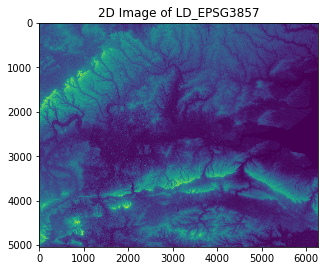

*==> The shape of the DEM array is: [5203, 6418].
>>>> Plot DEM image.


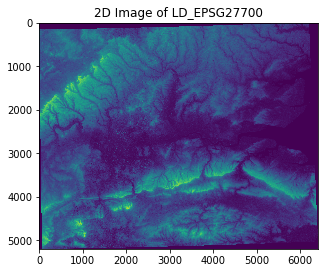

0

In [10]:
### Display merged and projected ASTGDEMv2 data in PCSs.

img_path = "IMG_ASTGDEMv2/"

# DEM in Web Mercator PCS.
dem_name = "ASTGDEMv2_merged_EPSG3857.tif"
img_name = "LD_EPSG3857"
show_ProjDEM(path, dem_name, img_path, img_name)

# DEM in BNG PCS.
dem_name = "ASTGDEMv2_merged_EPSG27700.tif"
img_name = "LD_EPSG27700"
show_ProjDEM(path, dem_name, img_path, img_name)


*==> The shape of the DEM array is: [3600, 7200].
>>>> Plot DEM image.


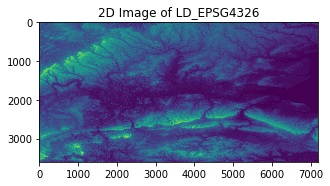

===> The number of rows of DEM array is: 3600 (height).
===> The number of cols of DEM array is: 7200 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform parameters of DEM data is:
(-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
===> The projection information of DEM data is:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


*==> The shape of the DEM array is: [3600, 7200].
>>>> Plot DEM image.


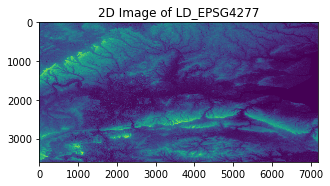

===> The number of rows of DEM array is: 3600 (height).
===> The number of cols of DEM array is: 7200 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform parameters of DEM data is:
(-0.9986513108124788, 0.00027780667700100285, 0.0, 51.99969924747907, 0.0, -0.00027780667700100285)
===> The projection information of DEM data is:
GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000044,AUTHORITY["EPSG","7001"]],TOWGS84[446.448,-125.157,542.06,0.15,0.247,0.842,-20.489],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4277"]]




In [11]:
# Display merged and unprojected ASTGDEMv2 data in GCSs.

img_path = "IMG_ASTGDEMv2/"

# DEM in Web Mercator PCS.
dem_name = "ASTGDEMv2_merged_EPSG4326.tif"
img_name = "LD_EPSG4326"
show_ProjDEM(path, dem_name, img_path, img_name)
data = gdal.Open(path + dem_name)
get_TifInfo(data, 1)
print('\n')

# DEM in BNG PCS.
dem_name = "ASTGDEMv2_merged_EPSG4277.tif"
img_name = "LD_EPSG4277"
show_ProjDEM(path, dem_name, img_path, img_name)
data = gdal.Open(path + dem_name)
get_TifInfo(data, 1)
print('\n')


In [12]:
### Read London air quality station data.

site_path = "DATA_LD_AirQuality/London_AirQuality_Stations.csv"
site_data_raw = read_csv(site_path)  # Station data (pandas.DF).
print(site_data_raw.head(3))
print('\n')

site_num = site_data_raw['SiteName'].count()  # The number of stations.
print(site_num)
print('\n')


  Unnamed: 0 api_data need_prediction  historical_data   Latitude  Longitude  \
0        BX9     True             NaN             True  51.465983   0.184877   
1        BX1     True             NaN             True  51.465983   0.184877   
2        BL0     True            True             True  51.522287  -0.125848   

           SiteType                   SiteName  
0          Suburban  Bexley - Slade Green FDMS  
1          Suburban       Bexley - Slade Green  
2  Urban Background        Camden - Bloomsbury  


24




In [13]:
### Read latitude and longitude of stations.

site_latlog = np.zeros((site_num, 2))  # The latitude and longitude of stations.
site_latlog[:, 0] = site_data_raw['Latitude']  # 0-th col - lat!
site_latlog[:, 1] = site_data_raw['Longitude']  # 1-th col - long!
np.set_printoptions(suppress=True)  # Print numbers without scientific notation.
print(site_latlog)
print('\n')


[[51.46598327  0.18487713]
 [51.46598327  0.18487713]
 [51.522287   -0.125848  ]
 [51.52770662 -0.12905321]
 [51.544219   -0.175284  ]
 [51.51452534 -0.10451563]
 [51.51384718 -0.07776568]
 [51.410039   -0.127523  ]
 [51.490532    0.074003  ]
 [51.45258     0.070766  ]
 [51.486957    0.095111  ]
 [51.456357    0.040725  ]
 [51.4563      0.085606  ]
 [51.617327   -0.298775  ]
 [51.52078746  0.20546071]
 [51.48878    -0.441627  ]
 [51.52104675 -0.21349214]
 [51.52104675 -0.21349214]
 [51.474954   -0.039641  ]
 [51.56948433  0.08290747]
 [51.42525604 -0.34560829]
 [51.3892869  -0.14166153]
 [51.51504617 -0.00841849]
 [51.52254    -0.15459   ]]




In [14]:
gcs_path = "DATA_ASTGDEMv2/EPSG4326_rm/"

gcs_wgs  = "ASTGDEMv2_merged_EPSG4326.tif"
gcs_osgb = "ASTGDEMv2_merged_EPSG4277.tif"


In [15]:
### Get elevation from ASTGDEMv2 data in WGS-84 GCS.

gcs_data = gdal.Open(gcs_path + gcs_wgs)

tag = 1
get_TifInfo(gcs_data, tag)

# Get elevation.
site_ele = get_Elevation(gcs_data, site_latlog)
np.set_printoptions(suppress=True)  # Print numbers without scientific notation.
print(site_ele)
print('\n')


===> The number of rows of DEM array is: 3600 (height).
===> The number of cols of DEM array is: 7200 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform parameters of DEM data is:
(-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)
===> The projection information of DEM data is:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
(-1.000138888888889, 0.0002777777777777778, 0.0, 52.00013888888889, 0.0, -0.0002777777777777778)


[[   0.           51.46598327    0.18487713 1923.         4266.
    18.        ]
 [   1.           51.46598327    0.18487713 1923.         4266.
    18.        ]
 [   2.           51.522287     -0.125848   1720.         3147.
    38.        ]
 [   3.           51.52770662   -0.12905321 1701.         3136.
    40.        ]
 [   4.           

In [16]:
### Get elevation from ASTGDEMv2 data in WGS-84 GCS.

gcs_data = gdal.Open(gcs_path + gcs_osgb)

tag = 1
get_TifInfo(gcs_data, tag)

# Get elevation.
site_ele = get_Elevation(gcs_data, site_latlog)
np.set_printoptions(suppress=True)  # Print numbers without scientific notation.
print(site_ele)
print('\n')


===> The number of rows of DEM array is: 3600 (height).
===> The number of cols of DEM array is: 7200 (width).
===> The number of bands of DEM array is: 1.
===> The 6 GeoTransform parameters of DEM data is:
(-0.9986513108124788, 0.00027780667700100285, 0.0, 51.99969924747907, 0.0, -0.00027780667700100285)
===> The projection information of DEM data is:
GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000044,AUTHORITY["EPSG","7001"]],TOWGS84[446.448,-125.157,542.06,0.15,0.247,0.842,-20.489],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4277"]]
(-0.9986513108124788, 0.00027780667700100285, 0.0, 51.99969924747907, 0.0, -0.00027780667700100285)


[[   0.           51.46598327    0.18487713 1921.         4260.
    14.        ]
 [   1.           51.46598327    0.18487713 1921.         4260.
    14.        ]
 [   2.           51.522287     -0.125848   1719.         3142.
    36.        ]
 [   3.           51